In [235]:
# this notebook compares rescaling of zstack using static theories or a dynamic scaling factor theory.
# for the comparison we use the data from Diel et al. Nat. Protocols 2020. Figure 5a.

#First load some packages
import psf_extra as psfe
import numpy as np
import matplotlib.pyplot as plt

def Lyakin(z,n_sample,n_im,NA):
    d = 1
    top = np.add(n_im,np.sqrt(np.subtract(np.power(n_im,2),np.power(NA,2))))
    bottom_1 = np.multiply(4,np.subtract(np.power(n_sample,2),np.power(n_im,2)))
    bottom_2 = np.add(n_im,np.emath.sqrt(np.subtract(np.power(n_im,2),np.power(NA,2))))
    bottom = np.real(np.emath.sqrt(np.add(bottom_1,np.power(bottom_2,2))))
    if bottom == 0: bottom=0.000000000000001
    dz = np.multiply(d,np.divide(top,bottom))
    scaling_factor = np.divide(1,dz)    
    return np.zeros(len(z)) + scaling_factor

def diel_mean(z,n_im,n_sample,NA):
    sum=0
    number_of_rays=10000 # paper uses 100, but this is still doable.
    for i in range(number_of_rays):
        k=i+1
        top     =  np.tan(np.arcsin(np.divide((NA*k),(np.multiply(number_of_rays,n_im)))))
        bottom  =  np.tan(np.arcsin(np.divide((NA*k),(np.multiply(number_of_rays,n_sample)))))
        sum +=np.divide(top,bottom)
    return np.zeros(len(z)) + np.divide(sum,number_of_rays)

def diel_median(z,n_im,n_sample,NA):
    top = np.tan(np.arcsin(np.divide(0.5*NA,n_im)))
    bottom = np.tan(np.arcsin(np.divide(0.5*NA,n_sample)))
    return np.zeros(len(z)) + np.divide(top,bottom)

def scaling_factor(z, NA,n1,n2,lam_0):
    n2overn1 = np.divide(n2,n1)
    
    if n2overn1 < 1: eps = np.multiply(-1,np.divide(np.divide(lam_0,4),(np.multiply(z,n2))))
    else: eps = np.divide(np.divide(lam_0,4),(np.multiply(z,n2)))
    eps_term = np.multiply(eps, np.subtract(2,eps))    
    
    m = np.emath.sqrt(np.subtract(np.power(n2,2),np.power(n1,2)))
    
    sf_univ = np.multiply(np.divide(n2,n1),
                          np.divide(1-eps+np.divide(m,n1)*np.emath.sqrt(eps_term),
                                    1-np.multiply(np.divide(n2,n1)**2,eps_term)))
#     sf_crit = np.divide(n1-np.emath.sqrt(np.power(n1,2)-np.power(NA,2)),
#                         n2-np.emath.sqrt(np.power(n2,2)-np.power(NA,2)))
    
    sf_crit = Lyakin([0],n2,n1,NA)[0]
    
    sf = np.zeros(len(z))
    for i in range(len(sf)):
        if n2overn1 < 1: sf[i] = np.max([np.real(sf_univ[i]),np.real(sf_crit)])
        elif n2overn1 > 1:sf[i] = np.min([np.real(sf_univ[i]),np.real(sf_crit)])
        else: sf[i]=1
    return sf

In [236]:
#load stacks
location = 'D:\\axial_scaling\\data_dieletal\\OneDrive_1_9-20-2023\\' #location of stacks
glyc_stack = psfe.load_stack(location+'tdtom_sx621_m1_sld2_slc3_whitematter_25x_1zoom_xyoptimal170_z103_s.tif')
air_stack = psfe.load_stack(location+'tdtom_sx621_m1_sld2_slc3_whitematter_20x_12zoom_xyoptimal170_zoptimal103_s.tif')

#invert z direction:
#glyc_stack = glyc_stack[::-1, :, :]
#air_stack = air_stack[::-1, :, :]

print('Done!')

Done!


In [237]:
#define some parameters
ps_x_glyc = 0.1693581 # um
ps_z_glyc = 1.0300000 # um

ps_x_air = 0.1692507 # um
ps_z_air = 1.0269321 # um

n_im = 1.0
n_sample = 1.46
NA = 0.8

shape_glyc = np.shape(glyc_stack)
shape_air = np.shape(air_stack)

print(shape_glyc)
print(shape_air)

(48, 1512, 1512)
(31, 1576, 1576)


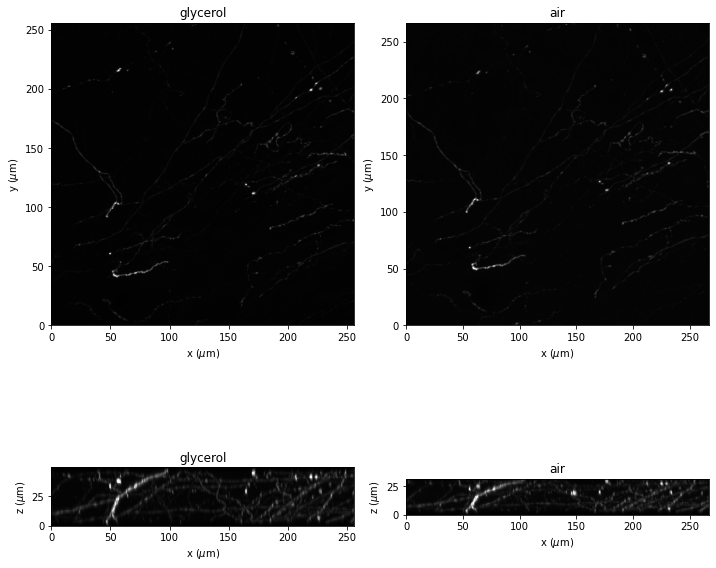

In [238]:
# plot MIPs of stacks
stacks = [glyc_stack,air_stack]
stack_names=['glycerol','air']
planes=['xy','xz']
fig,axs=plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(len(stack_names)):
    for j in range(len(planes)):
        if planes[j] == 'xy': 
            mip_axis = 0 
            if stack_names[i]=='air': extent = [0, shape_air[2]*ps_x_air, 0, shape_air[1]*ps_x_air]
            else: extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[1]*ps_x_glyc]
        else: 
            mip_axis = 1
            if stack_names[i]=='air': extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*ps_z_air]
            else: extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[0]*ps_z_glyc]
        
        axs[j,i].imshow(np.max(stacks[i], axis=mip_axis),cmap='gray',extent=extent)
        axs[j,i].set_title(stack_names[i])
        axs[j,i].set_xlabel(planes[j][:1]+r' ($\mu$m)')
        axs[j,i].set_ylabel(planes[j][1:]+r' ($\mu$m)')
plt.tight_layout()
plt.show()

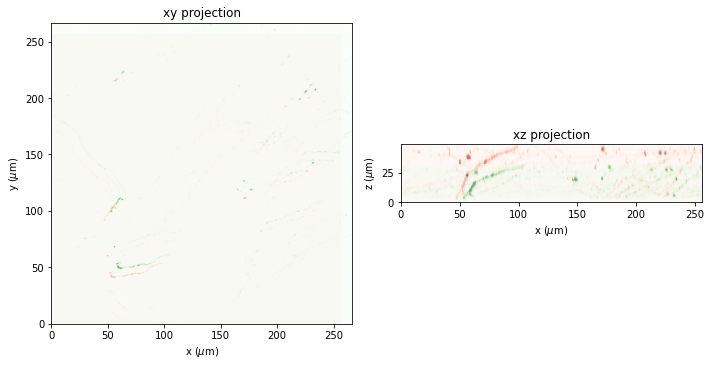

In [239]:
#plot overlays

fig,axs=plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)
colormaps=['Reds','Greens']
for i in range(len(stack_names)):
    for j in range(len(planes)):
        if planes[j] == 'xy': 
            mip_axis = 0 
            if stack_names[i]=='air': extent = [0, shape_air[2]*ps_x_air, 0, shape_air[1]*ps_x_air]
            else: extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[1]*ps_x_glyc]
        else: 
            mip_axis = 1
            if stack_names[i]=='air': extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*ps_z_air]
            else: extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[0]*ps_z_glyc]
        
        axs[j].imshow(np.max(stacks[i], axis=mip_axis),cmap=colormaps[i],extent=extent,alpha=0.5,label=stack_names[i])
        axs[j].set_title(planes[j]+' projection')
        axs[j].set_xlabel(planes[j][:1]+r' ($\mu$m)')
        axs[j].set_ylabel(planes[j][1:]+r' ($\mu$m)')
axs[1].set_xlim(0, shape_glyc[2]*ps_x_glyc)
axs[1].set_ylim(0, shape_glyc[0]*ps_z_glyc)

plt.tight_layout()
plt.show()

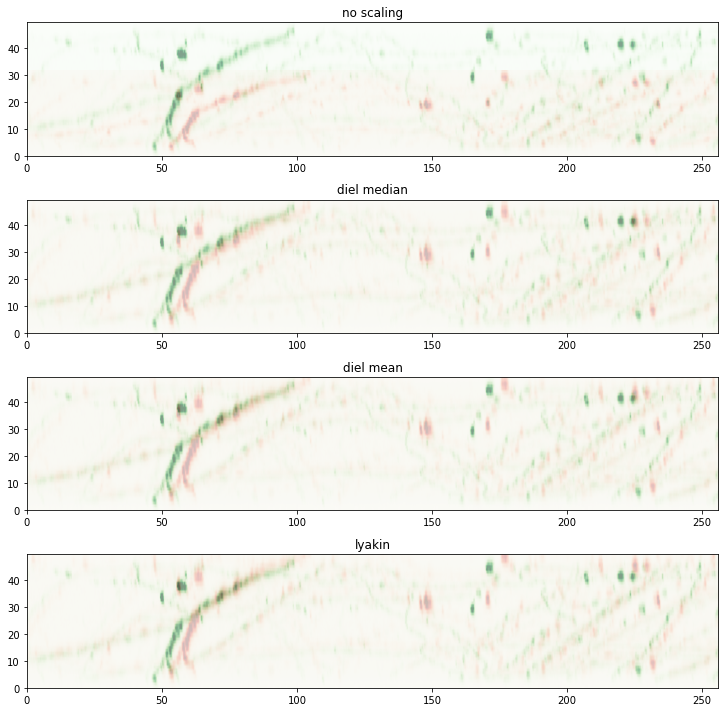

In [240]:
# rescale air data set using static theories (lyakin, diel median, diel mean)
# only plot xz planes:

ps_z_air_diel_median = ps_z_air * diel_median([1],n_im,n_sample,NA)[0]
ps_z_air_diel_mean = ps_z_air * diel_mean([1],n_im,n_sample,NA)[0]
ps_z_air_lyakin = ps_z_air * Lyakin([1],n_sample,n_im,NA)[0]
theories = ['no scaling','diel median', 'diel mean','lyakin']
rescaled_ps_z = [ps_z_air, ps_z_air_diel_median,ps_z_air_diel_mean,ps_z_air_lyakin]

fig,axs = plt.subplots(4,1)
fig.set_figheight(10)
fig.set_figwidth(20)
for i in range(len(theories)):
    theory = theories[i]
    axs[i].set_title(theories[i])
    extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*rescaled_ps_z[i]]
    axs[i].imshow(np.max(air_stack, axis=1),cmap='Reds',extent=extent,alpha=0.5)
    extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[0]*ps_z_glyc]
    axs[i].imshow(np.max(glyc_stack, axis=1),cmap='Greens',extent=extent,alpha=0.5)
    axs[i].set_xlim(0, shape_glyc[2]*ps_x_glyc)
    axs[i].set_ylim(0, shape_glyc[0]*ps_z_glyc)
plt.tight_layout()
plt.show()

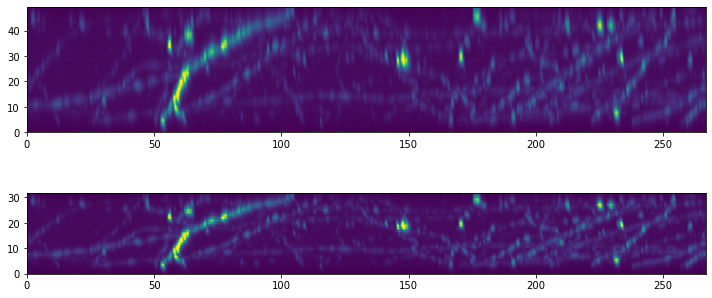

In [241]:
# how to correct using dynamic theory?
# project resulting array onto glycerol steps
# plan:
# make new stack with glycerol stack dimensions
# calculate for each slice in air stack what the real position in z is.
# then run over each slide in new stack, and identify the two nearest slides in air stack.
# then give slide in new stack intensities weigthed by distance to the two nearest slides in air stack.
# I (z) = ( dz(-1) * I(dz(-1)) + dz(+1) * I(dz(+1)) / dz(-1)+dz(+1)) 

# make list of real distances in air stack using depth-dependent scaling factor
nfp_air_stack = np.arange(shape_air[0])*ps_z_air
nfp_air_stack[0]=0.00000001 # prevent function from blowing up
sf_air_stack = scaling_factor(nfp_air_stack, NA,n_im,n_sample,0.52)
nfp_air_stack[0]=0.000000 # prevent function from blowing up
sf_air_stack[0]=sf_air_stack[1] # equation get unphysical when z -> 0, therefore replace with next number (cheating, I know)
afp_air_stack = nfp_air_stack*sf_air_stack

#make list of distances in glycerol stack
afp_glyc_stack = np.arange(shape_glyc[0])*ps_z_glyc

#make empty array we will fill with intensities of rescaled stack
air_stack_rescaled=np.empty([shape_glyc[0],shape_air[1],shape_air[2]])



#run over slices in new stack:
for i in range(shape_glyc[0]):
    #print(i)
    if i == 0: #first slide, no rescaling
        air_stack_rescaled[i] = air_stack[0]
    else:
        afp_slide = afp_glyc_stack[i] #get depth of new stack
        #find two nearest slides in air stack and there z position (AFP)
        index, value =min(enumerate(afp_air_stack), key=lambda x: abs(x[1]-afp_slide))
        if afp_slide > value: indices = [index, index+1]
        else: indices = [index-1, index]
        value_under, value_upper = afp_air_stack[indices[0]],afp_air_stack[indices[1]]
        dz_under, dz_upper = afp_slide - value_under, value_upper - afp_slide
        dz_under_inv, dz_upper_inv=1/dz_under, 1/dz_upper
        dz_sum = dz_under + dz_upper
        dz_inv_sum = dz_under_inv + dz_upper_inv
        # make new slide from two closest slides
        #new_slide = np.multiply(air_stack[indices[0],:,:],(dz_under/dz_sum))+np.multiply(air_stack[indices[1],:,:],(dz_upper/dz_sum))
        new_slide = np.divide(np.multiply(air_stack[indices[0],:,:],dz_under_inv)+np.multiply(air_stack[indices[1],:,:],dz_upper_inv),dz_inv_sum)
        #this used inverse distance weighting with power of 1: https://en.wikipedia.org/wiki/Inverse_distance_weighting
        # print('\n\t\t Slide pos: Intensity:')
        # print('Slide new: \t', afp_slide, '\t', new_slide[0,0])
        # print('Slide under: \t', value_under, '\t', air_stack[indices[0],0,0])
        # print('Slide upper: \t', value_upper, '\t', air_stack[indices[1],0,0])
        
        
        air_stack_rescaled[i] = new_slide
#fig,ax=plt.subplots(3,1)
fig,ax=plt.subplots(2,1)
fig.set_figheight(5)
fig.set_figwidth(10)
ax[0].imshow(np.max(air_stack_rescaled,axis=1),extent = [0, shape_air[2]*ps_x_air, 0, shape_glyc[0]*ps_z_glyc])
ax[1].imshow(np.max(air_stack,axis=1),extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*ps_z_air])
#ax[2].imshow(np.max(air_stack,axis=1),extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*ps_z_air_diel_median])
axs[0].set_xlim(0, shape_glyc[2]*ps_x_glyc)
axs[0].set_ylim(0, shape_glyc[0]*ps_z_glyc)
axs[1].set_xlim(0, shape_glyc[2]*ps_x_glyc)
axs[1].set_ylim(0, shape_glyc[0]*ps_z_glyc)
# axs[2].set_xlim(0, shape_glyc[2]*ps_x_glyc)
# axs[2].set_ylim(0, shape_glyc[0]*ps_z_glyc)
plt.tight_layout()
plt.show()

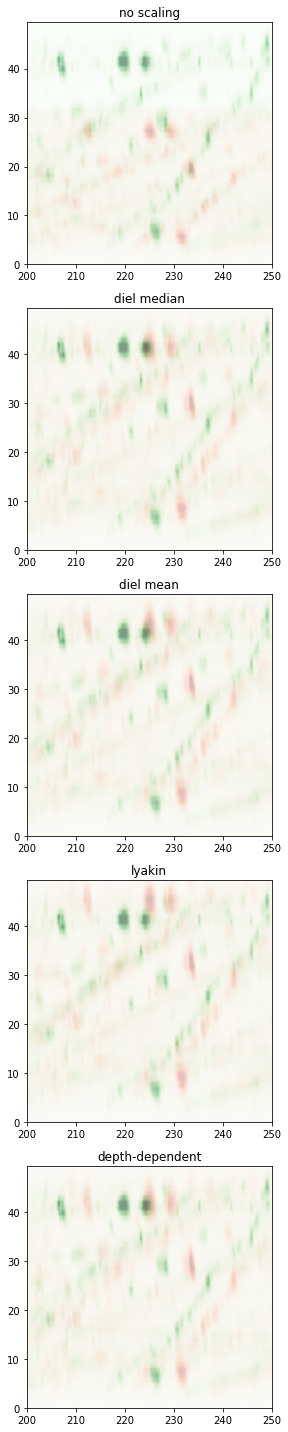

In [246]:
theories = ['no scaling','diel median', 'diel mean','lyakin','depth-dependent']
rescaled_ps_z = [ps_z_air, ps_z_air_diel_median,ps_z_air_diel_mean,ps_z_air_lyakin,ps_z_glyc]

fig,axs = plt.subplots(5,1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(theories)):
    theory = theories[i]
    axs[i].set_title(theories[i])
    if i != len(theories)-1:
        extent = [0, shape_air[2]*ps_x_air, 0, shape_air[0]*rescaled_ps_z[i]]
        axs[i].imshow(np.max(air_stack, axis=1),cmap='Reds',extent=extent,alpha=0.5)
    else: 
        extent = [0, shape_air[2]*ps_x_air, 0, shape_glyc[0]*ps_z_glyc]
        axs[i].imshow(np.max(air_stack_rescaled, axis=1),cmap='Reds',extent=extent,alpha=0.5)
    extent = [0, shape_glyc[2]*ps_x_glyc, 0, shape_glyc[0]*ps_z_glyc]
    axs[i].imshow(np.max(glyc_stack, axis=1),cmap='Greens',extent=extent,alpha=0.5)
    #axs[i].set_xlim(0, shape_glyc[2]*ps_x_glyc)
    axs[i].set_xlim(200, 250)
    axs[i].set_ylim(0, shape_glyc[0]*ps_z_glyc)
    
plt.tight_layout()
plt.show()

In [243]:
#print sum of all slices in afp_air and compare to total size of glyc stack
print((afp_air_stack[-1]))
print(len(glyc_stack)*ps_z_glyc)
print([0, shape_air[2]*ps_x_air, 0, shape_glyc[0]*ps_z_glyc])

49.08878826552019
49.44
[0, 266.7391032, 0, 49.44]
